<a href="https://colab.research.google.com/github/illusoryTwin/mujoco_unitree_a1/blob/menagerie_model/unitree_a1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation

In [1]:
!pip install mujoco

# Set up GPU rendering.
from google.colab import files
import distutils.util
import os
import subprocess
# if subprocess.run('nvidia-smi').returncode:
#   raise RuntimeError(
#       'Cannot communicate with GPU. '
#       'Make sure you are using a GPU Colab runtime. '
#       'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

# Check if installation was succesful.
try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

# Other imports and helper functions
import numpy as np
from typing import Callable, Optional, Union, List
import scipy.linalg

# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

from IPython.display import clear_output
clear_output()


In [3]:
print("Get the unitree a1 model")
!git clone https://github.com/deepmind/mujoco_menagerie

Get the unitree a1 model
Cloning into 'mujoco_menagerie'...
remote: Enumerating objects: 2272, done.
remote: Counting objects: 100% (638/638), done.
remote: Compressing objects: 100% (404/404), done.
remote: Total 2272 (delta 347), reused 361 (delta 234), pack-reused 1634
Receiving objects: 100% (2272/2272), 216.68 MiB | 22.87 MiB/s, done.
Resolving deltas: 100% (881/881), done.
Updating files: 100% (1173/1173), done.


# Import the model

In [24]:
import mujoco

# Set the model
model = mujoco.MjModel.from_xml_path("mujoco_menagerie/unitree_a1/scene.xml")
data = mujoco.MjData(model)

# Set the renderer for visualization
renderer = mujoco.Renderer(model)

In [25]:
# Try random control. Simulate and display video.

model = mujoco.MjModel.from_xml_path("mujoco_menagerie/unitree_a1/scene.xml")
data = mujoco.MjData(model)

# Set the renderer for visualization
renderer = mujoco.Renderer(model)

duration = 10.3  # (seconds)
framerate = 60  # (Hz)

frames = []

while data.time < duration:

    mujoco.mj_step(model, data)

    # Apply some random control
    data.ctrl = [0.9, 0.5, 0.5, 0, 0, 0, 0, 0, 0.9, 0.9, 0.5, 0.5]

    # print(data.time, data.qpos, data.qvel)
    if len(frames) < data.time * framerate:
        renderer.update_scene(data)
        pixels = renderer.render()
        frames.append(pixels)

media.show_video(frames, fps=framerate)

# Fix the model stable

Check control
 data.ctrl [ 0.   0.9 -1.8  0.   0.9 -1.8  0.   0.9 -1.8  0.   0.9 -1.8]


""

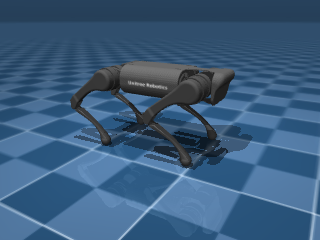

In [26]:
# Fix the model at the specific position

mujoco.mj_resetDataKeyframe(model, data, 0)
mujoco.mj_forward(model, data)
print("Check control\n data.ctrl", data.ctrl)
renderer.update_scene(data)
media.show_image(renderer.render())

""

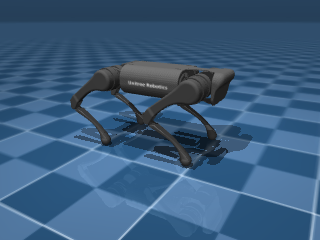

In [27]:
# Solve inverse dynamics for a stable state

mujoco.mj_resetDataKeyframe(model, data, 0)
mujoco.mj_forward(model, data)
data.qacc = 0  # Assert that there is no the acceleration.
mujoco.mj_inverse(model, data)

renderer.update_scene(data)
media.show_image(renderer.render())

In [28]:
qfrc0 = data.qfrc_inverse.copy()
print(qfrc0, "qfrc0")

[  0.      0.    122.164   0.19    1.377   0.     -0.816   0.344  -0.236   0.816   0.344  -0.236
  -0.816   0.344  -0.236   0.816   0.344  -0.236] qfrc0


In [29]:
ctrl0 = np.atleast_2d(qfrc0) @ np.linalg.pinv(data.actuator_moment)
ctrl0 = ctrl0.flatten()  # Save the ctrl setpoint.
print("ctrl0", ctrl0)

duration = 5.3  # (seconds)
framerate = 60  # (Hz)

frames = []

while data.time < duration:

    mujoco.mj_step(model, data)

    # Do your control here!
    data.ctrl = ctrl0
    # data.ctrl = np.random.randn(model.nu) # random control

    # print(data.time, data.qpos, data.qvel)
    if len(frames) < data.time * framerate:
        renderer.update_scene(data)
        pixels = renderer.render()
        frames.append(pixels)

media.show_video(frames, fps=framerate)

ctrl0 [-0.816  0.344 -0.236  0.816  0.344 -0.236 -0.816  0.344 -0.236  0.816  0.344 -0.236]


In [30]:
nu = model.nu
nv = model.nv

# Allocate the A and B matrices, compute them.
A = np.zeros((2*nv, 2*nv))
B = np.zeros((2*nv, nu))
epsilon = 1e-6
centered = True
mujoco.mjd_transitionFD(model, data, epsilon, centered, A, B, None, None)
print("A", A)
print("B", B)

A [[ 1.     0.     0.003 ...  0.     0.     0.   ]
 [ 0.     1.    -0.    ... -0.    -0.     0.   ]
 [ 0.     0.     0.99  ...  0.     0.    -0.   ]
 ...
 [-0.     0.    -2.836 ...  0.804 -0.     0.002]
 [ 0.     0.    -1.113 ... -0.001  0.812 -0.009]
 [-0.    -0.     5.384 ...  0.001 -0.008  0.833]]
B [[ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.    -0.     0.     0.     0.     0.     0.    -0.     0.     0.     0.     0.   ]
 [ 0.    -0.     0.     0.    -0.     0.     0.    -0.     0.     0.    -0.     0.   ]
 [ 0.     0.     0.     0.    -0.     0.     0.     0.     0.     0.    -0.     0.   ]
 [ 0.    -0.     0.     0.    -0.     0.     0.    -0.     0.     0.    -0.     0.   ]
 [ 0.     0.     0.     0.    -0.     0.     0.     0.     0.     0.    -0.     0.   ]
 [ 0.    -0.     0.     0.    -0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.   ]


# Some tests

In [ ]:


# data.ctrl = [0.5, ]
# # mujoco.mj_step(model, data)
# mujoco.mj_forward(model, data)
# print("data.ctrl", data.ctrl)
# renderer.update_scene(data)
# media.show_image(renderer.render())

data.ctrl [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]


""

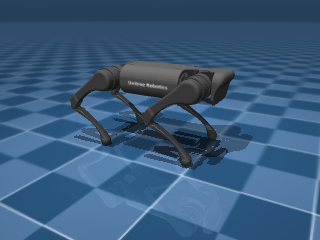

In [ ]:
# Control doesn't work
mujoco.mj_resetDataKeyframe(model, data, 0)
mujoco.mj_forward(model, data)
data.ctrl = [0.5]*12
# mujoco.mj_step(model, data)
mujoco.mj_forward(model, data)
print("data.ctrl", data.ctrl)
renderer.update_scene(data)
media.show_image(renderer.render())

""

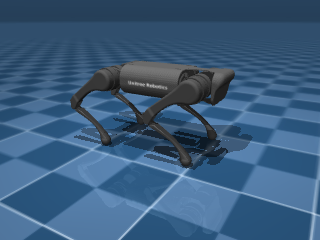

In [ ]:
# Fix the model at the specific position

mujoco.mj_resetDataKeyframe(model, data, 0)
mujoco.mj_forward(model, data)
renderer.update_scene(data)
media.show_image(renderer.render())

model.nkey 1
key 0


""

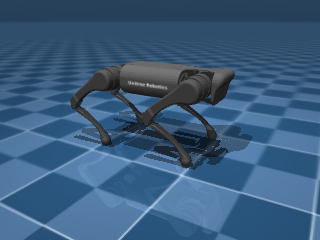

In [ ]:
# Check
print("model.nkey", model.nkey)
for key in range(model.nkey):
  print("key", key)
  mujoco.mj_resetDataKeyframe(model, data, key)
  mujoco.mj_forward(model, data)
  renderer.update_scene(data)
  media.show_image(renderer.render())


# Main code

""

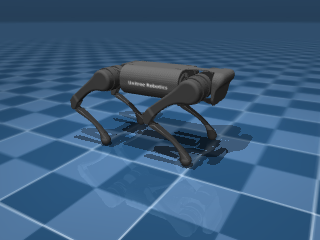

In [ ]:
for key in range(model.nkey):
  mujoco.mj_resetDataKeyframe(model, data, key)
  mujoco.mj_forward(model, data)
  renderer.update_scene(data)
  media.show_image(renderer.render())

In [ ]:
mujoco.mj_resetDataKeyframe(model, data, 0)
mujoco.mj_forward(model, data)
data.qacc = 0  # Assert that there is no the acceleration.
mujoco.mj_inverse(model, data)


# mujoco.mj_resetDataKeyframe(model, data, 1)
# mujoco.mj_forward(model, data)
# data.qacc = 0
# mujoco.mj_inverse(model, data)

In [ ]:
qfrc0 = data.qfrc_inverse.copy()
print(qfrc0, "qfrc0")

[  0.      0.    122.164   0.19    1.377   0.     -0.816   0.344  -0.236   0.816   0.344  -0.236
  -0.816   0.344  -0.236   0.816   0.344  -0.236] qfrc0


In [ ]:
ctrl0 = np.atleast_2d(qfrc0) @ np.linalg.pinv(data.actuator_moment)
ctrl0 = ctrl0.flatten()  # Save the ctrl setpoint.


duration = 5.3  # (seconds)
framerate = 60  # (Hz)

frames = []

while data.time < duration:

    mujoco.mj_step(model, data)

    # Do your control here!
    data.ctrl = ctrl0
    # data.ctrl = np.random.randn(model.nu)

    # print(data.time, data.qpos, data.qvel)
    if len(frames) < data.time * framerate:
        renderer.update_scene(data)
        pixels = renderer.render()
        frames.append(pixels)

media.show_video(frames, fps=framerate)



StopIteration: 

12 len(data.ctrl)


""

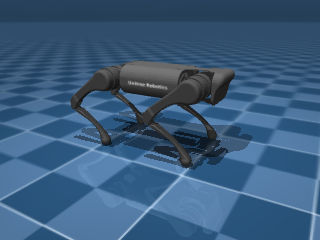

In [ ]:
ctrl0 = np.atleast_2d(qfrc0) @ np.linalg.pinv(data.actuator_moment)
ctrl0 = ctrl0.flatten()  # Save the ctrl setpoint.

# data.ctrl = ctrl0
data.ctrl = [0]*12
print(len(data.ctrl), "len(data.ctrl)")
mujoco.mj_forward(model, data)
media.show_image(renderer.render())


""

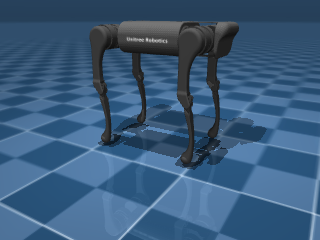

In [ ]:
mujoco.mj_resetDataKeyframe(model, data, 1)

data.ctrl = ctrl0
mujoco.mj_forward(model, data)

# mujoco.mj_step(model, data)

# renderer.update_scene(data) #, "fixed")
media.show_image(renderer.render())



# mujoco.mj_resetDataKeyframe(model, data, 1)
# mujoco.mj_forward(model, data)
# data.qacc = 0  # Assert that there is no the acceleration.
# mujoco.mj_inverse(model, data)
# print(data.qfrc_inverse)
# media.show_image(renderer.render())



In [ ]:
DURATION = 3
FRAMERATE = 60

while data.time < DURATION:
  # Render and save frames
  if len(frames) < data.time * FRAMERATE:
    # Set the lookat point to the humanoid's center of mass.
    # camera.lookat = data.body('trunk').subtree_com

    camera.lookat = data.body('FL_calf').subtree_com

    renderer.update_scene(data, camera)
    pixels = renderer.render()
    frames.append(pixels)

media.show_video(frames, fps=FRAMERATE)

KeyboardInterrupt: 

In [ ]:
DURATION  = 3   # seconds
FRAMERATE = 60  # Hz

# Make a new camera, move it to a closer distance.
camera = mujoco.MjvCamera()
mujoco.mjv_defaultFreeCamera(model, camera)
camera.distance = 2

mujoco.mj_resetDataKeyframe(model, data, 1)

frames = []
while data.time < DURATION:
  # Set control vector.
  data.ctrl = ctrl0
  # data.ctrl = np.random.randn(model.nu)
  # data.ctrl = [0.8]*12
  # Step the simulation.
  nu = model.nu
  nv = model.nv
# Allocate the A and B matrices, compute them.
  A = np.zeros((2*nv, 2*nv))
  B = np.zeros((2*nv, nu))
  epsilon = 1e-6
  centered = True
  mujoco.mjd_transitionFD(model, data, epsilon, centered, A, B, None, None)
  mujoco.mj_step(model, data)

  # Render and save frames
  if len(frames) < data.time * FRAMERATE:
    # Set the lookat point to the humanoid's center of mass.
    # camera.lookat = data.body('trunk').subtree_com

    camera.lookat = data.body('FL_calf').subtree_com

    renderer.update_scene(data, camera)
    pixels = renderer.render()
    frames.append(pixels)

media.show_video(frames, fps=FRAMERATE)